In [1]:
#basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

#data
import scipy.io as sio
from dataset import SURREALDataset, SittingDataset
from torch.utils.data import DataLoader

#pytorch
import torch
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
import torch.optim as optim
from torch.autograd import Variable

#models
from models import unet11

#train
from train import Trainer
from metrics import Soft_dice_loss

In [2]:
#######Usefull_functions#######

def show_pics(imgs, col, row):
    fig = plt.figure(figsize=(5*col,5*row))
    for i in range(0, col*row):
        fig.add_subplot(row, col, i + 1)
        if i < len(imgs):
            plt.imshow(imgs[i])
            plt.title('Class ' + str(i+1))
        plt.axis("off")
        
def binarize_classes(classes, num):
    classes_bin = np.zeros((num, classes.shape[0], classes.shape[1]))
    for i in range(len(classes)):
        row = classes[i]
        for j in range(len(row)):
            classes_bin[int(row[j]), i, j] = 1.0
            
    return classes_bin

## SURREAL DATASET
[download here](http://www.di.ens.fr/willow/research/surreal/)

In [3]:
sur_tr = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0'
sur_ts = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/test/run0'
sur_val = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/val/run0'

*  ### Demonstration

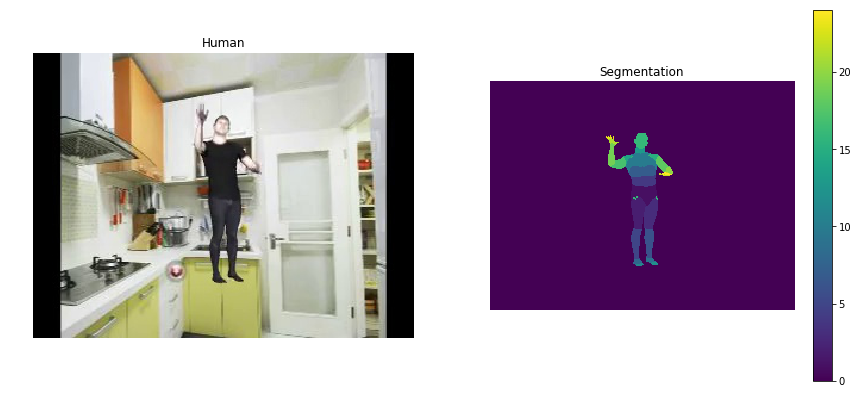

In [4]:
sur = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0/143_20/143_20_c0002frame1.jpg'
map_sur = sio.loadmat('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0/143_20/143_20_c0002_segm.mat')['segm_1']

fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow(plt.imread(sur))
plt.title('Human')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(map_sur)
plt.title('Segmentation')
plt.colorbar()
plt.axis("off");

In [5]:
map_sur = binarize_classes(map_sur, 25)

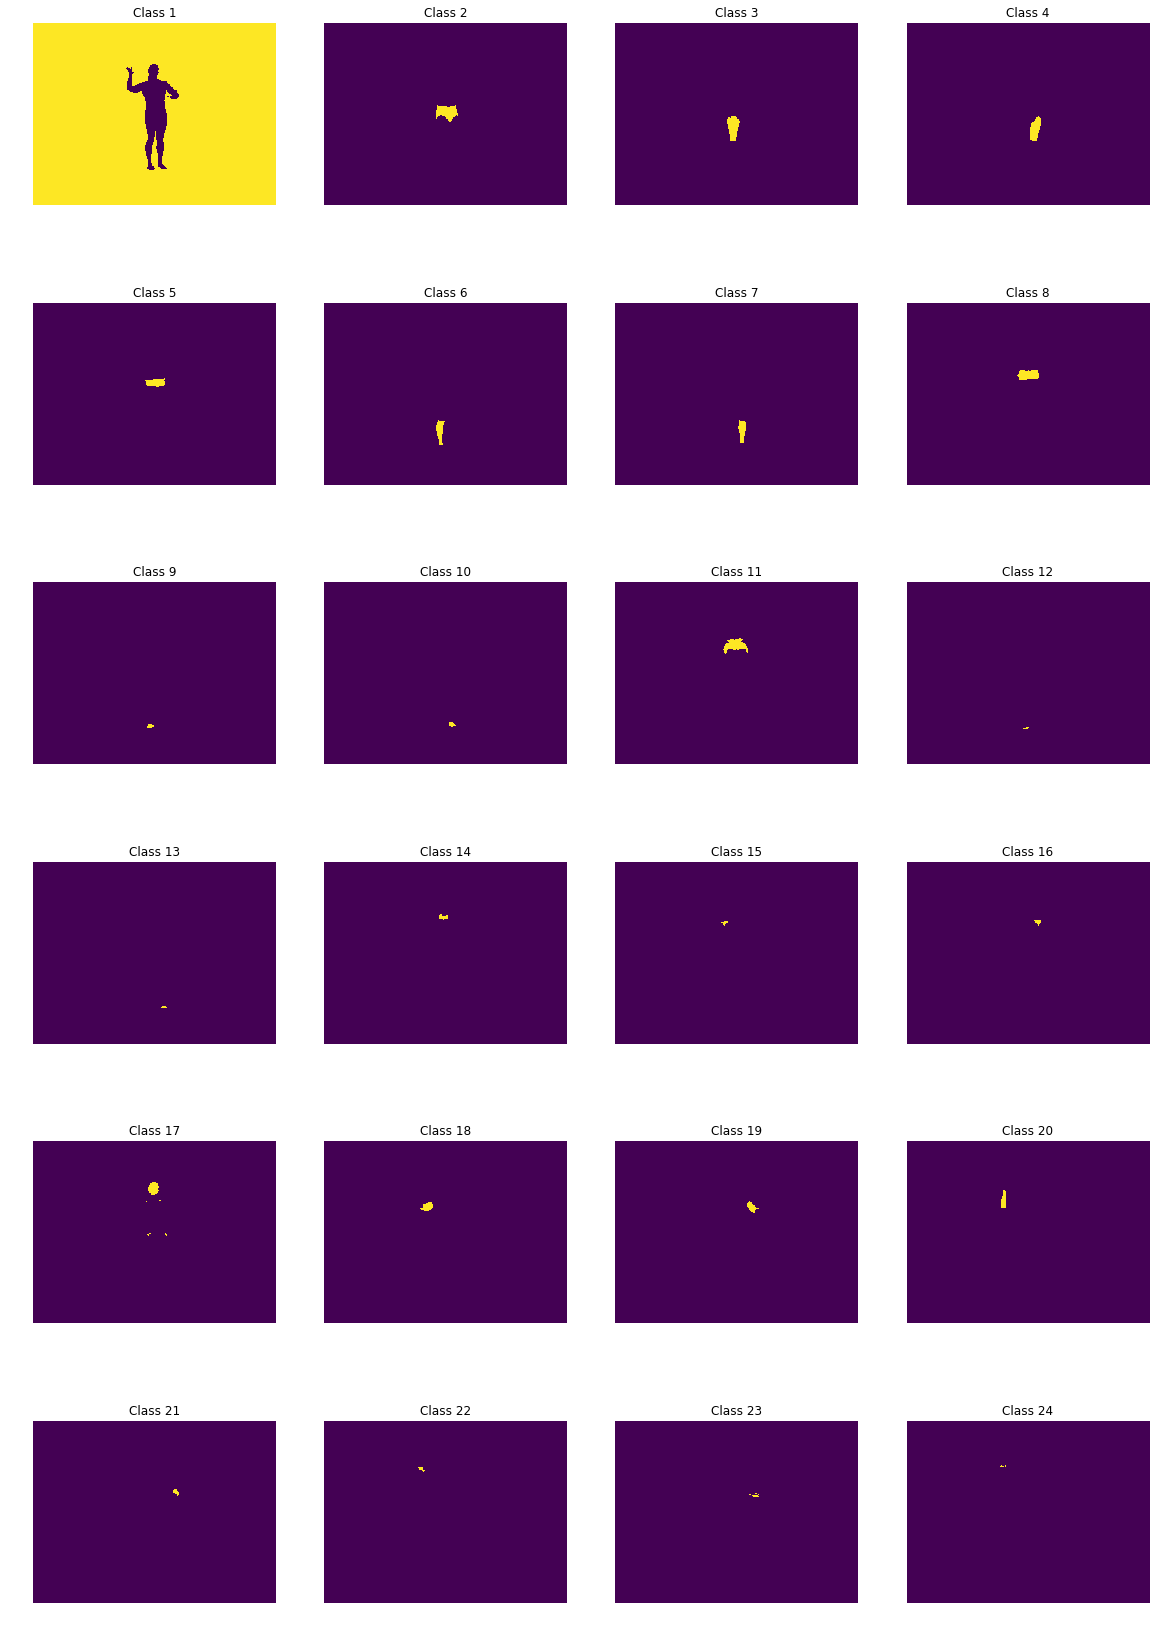

In [6]:
show_pics(map_sur, 4, 6)

## SITTING PEOPLE DATASET
[download here](http://www2.informatik.uni-freiburg.de/~oliveira/dataset.html)

In [4]:
sit_dirr = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img'

*   ### Demonstration

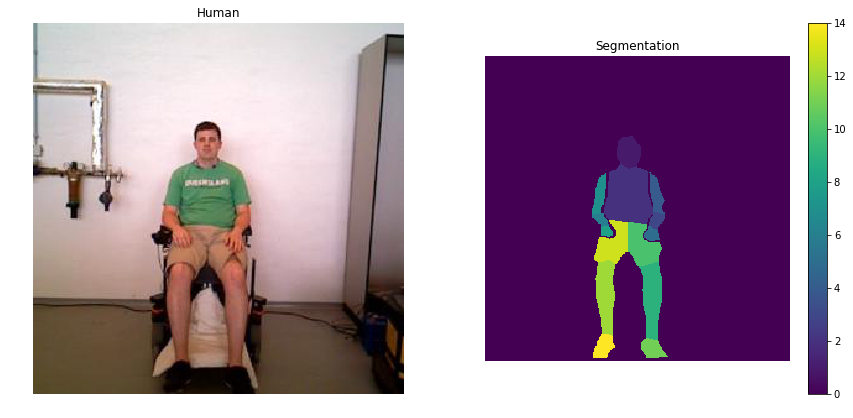

In [8]:
sit = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img/image90.jpg'
map_sit = sio.loadmat('/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/masks/image90.mat')['M']

fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow(plt.imread(sit))
plt.title('Human')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(map_sit)
plt.title('Segmentation')
plt.colorbar()
plt.axis("off");

In [9]:
map_sit = binarize_classes(map_sit, 15)

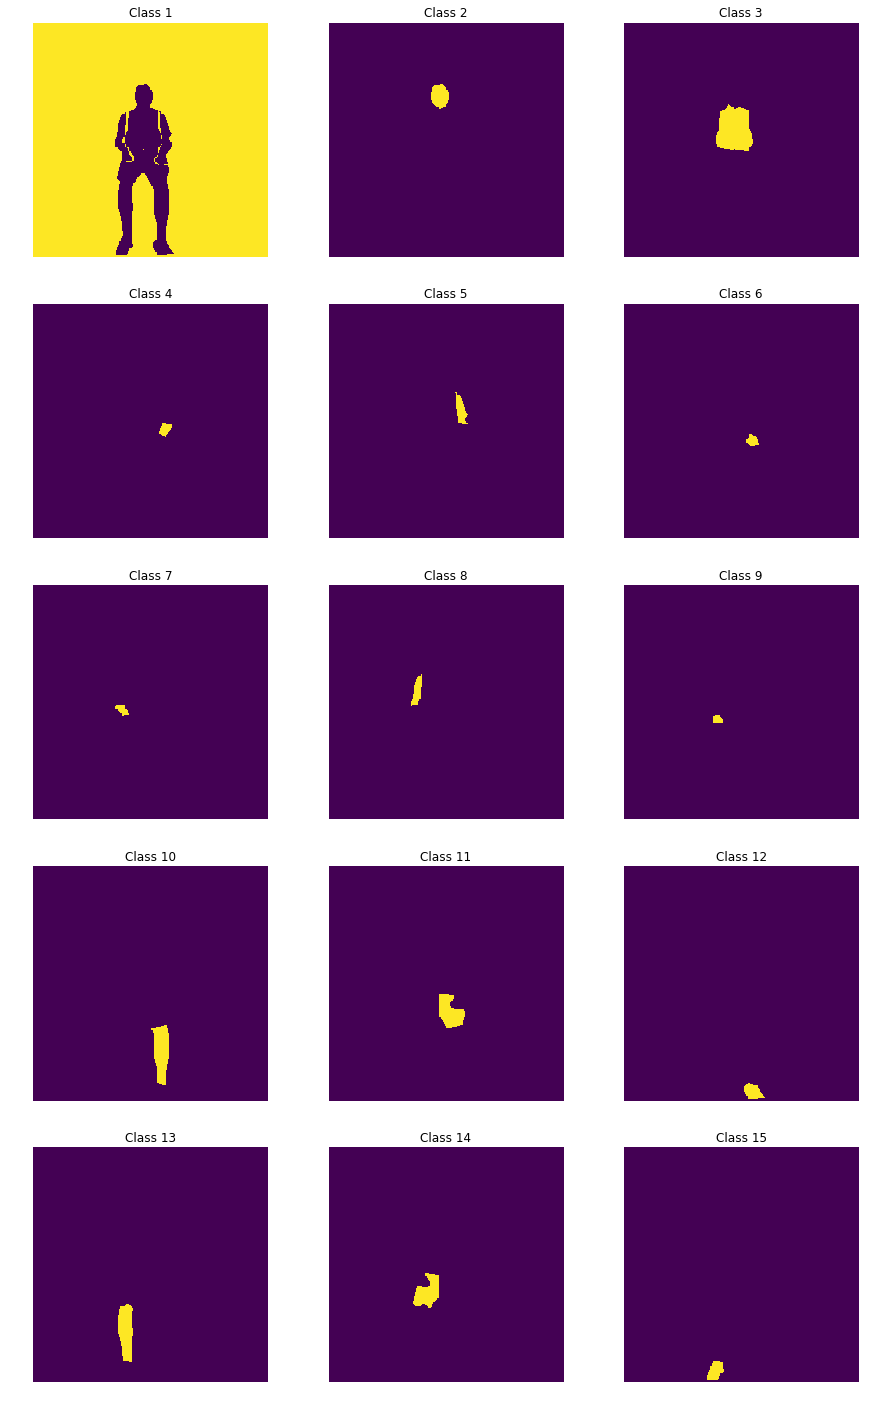

In [10]:
show_pics(map_sit, 3, 5)

*  ### Re-structed segmentation maps
(8 classes + 0 class background)

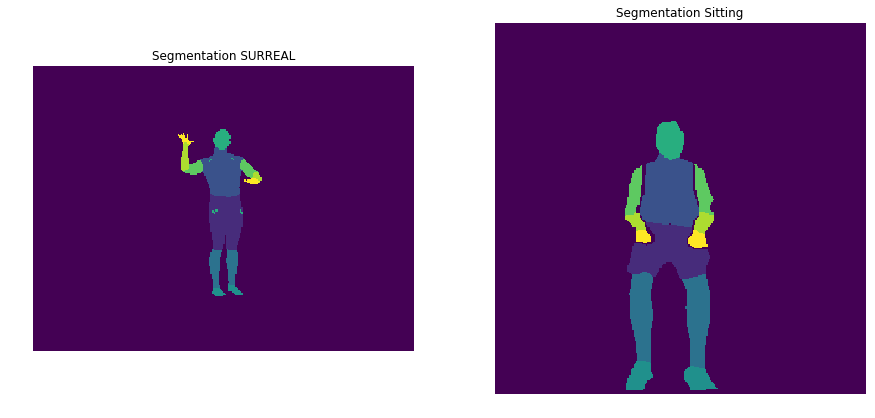

In [11]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow((map_sur[1] + map_sur[2] + map_sur[3]) +
          (map_sur[5] + map_sur[6])*3 +
          (map_sur[4] + map_sur[7] + map_sur[10] + map_sur[13] + map_sur[14] + map_sur[15])*2 +
          (map_sur[8] + map_sur[9] + map_sur[11] + map_sur[12])*4 + map_sur[16]*5 + 
          (map_sur[17] + map_sur[18])*6 + (map_sur[19] + map_sur[20])*7 +
          (map_sur[21] + map_sur[22] + map_sur[23] + map_sur[24])*8)

plt.title('Segmentation SURREAL')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(map_sit[1]*5 + map_sit[2]*2 + (map_sit[3] + map_sit[6])*7 + 
          (map_sit[4] + map_sit[7])*6 + (map_sit[5] + map_sit[8])*8 +
          (map_sit[9] + map_sit[12])*3 + (map_sit[10] + map_sit[13]) +
          (map_sit[11] + map_sit[14])*4)
plt.title('Segmentation Sitting')
plt.axis("off");

### SURREAL Dataset for pre-training.

In [5]:
transf = Compose([
    ToTensor()
])

# identifier='restructed' means that we are going to get only 9 classes, described above
dset_train = SURREALDataset(sur_tr, 9, transf, identifier='restructed', lengt=10000)
dset_test = SURREALDataset(sur_ts, 9, transf, identifier='restructed', lengt=10000)
dset_val = SURREALDataset(sur_val, 9, transf, identifier='restructed', lengt=10000)

In [6]:
batch_sz = 4
train_loader = DataLoader(dset_train, batch_size=batch_sz, shuffle=False)
test_loader = DataLoader(dset_test, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(dset_val, batch_size=batch_sz, shuffle=True)

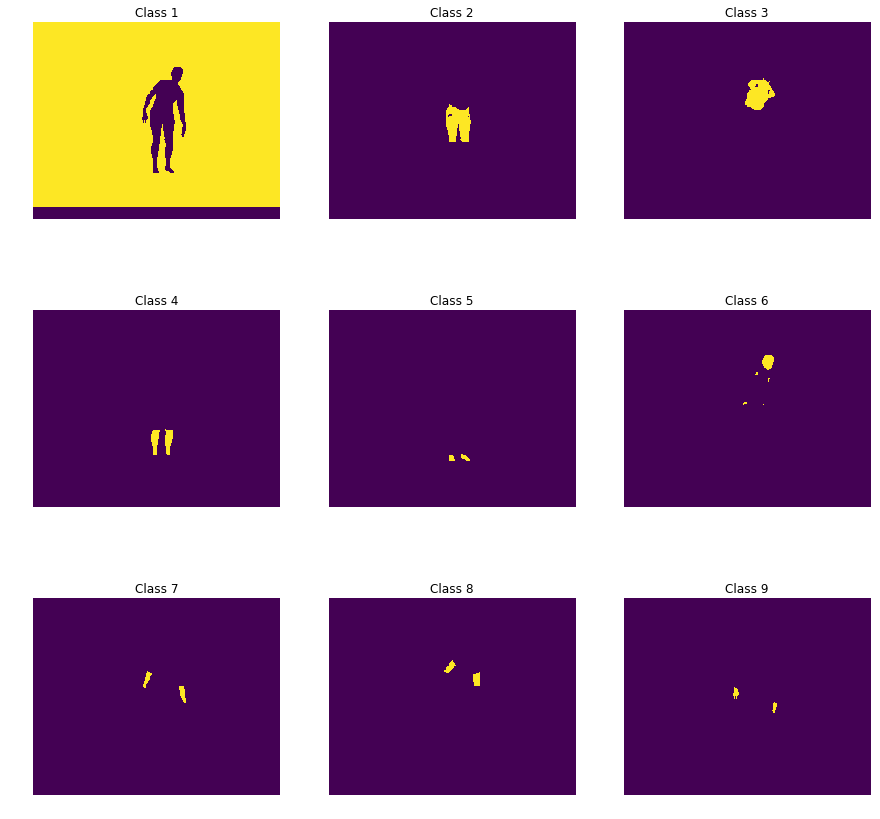

In [7]:
inputs_sur, classes_sur = next(iter(train_loader))
show_pics(classes_sur[0], 3, 3 )

### Sitting People Dataset.

In [13]:
dset_sitting = SittingDataset(sit_dirr, 9, transf, identifier='restructed')
sitting_loader = DataLoader(dset_sitting, batch_size=batch_sz, shuffle=True)

In [16]:
inputs_sit, classes_sit = next(iter(sitting_loader))

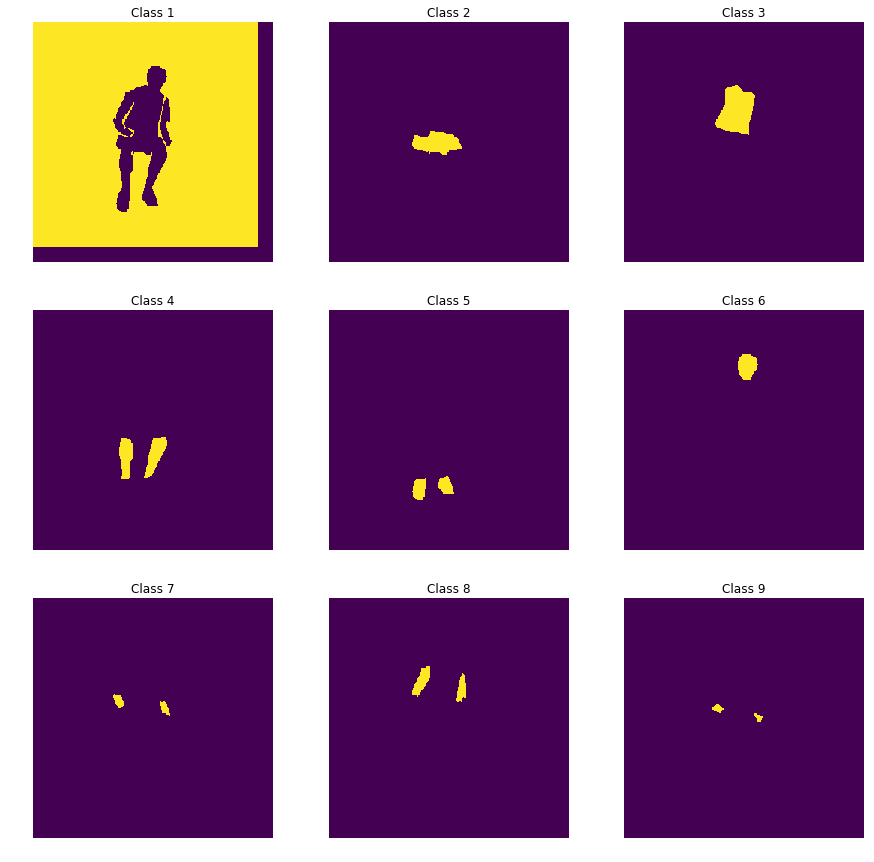

In [17]:
show_pics(classes_sit[0], 3, 3)

## TernausNet
* ### Only VGG11 pre-trained

In [20]:
num_classes = 9
num_epochs = 10
model = unet11(num_classes)

In [21]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=1,
    verbose=True,
    threshold=0.1
)

In [ ]:
loss = Soft_dice_loss(smooth=1e-15)
train = Trainer(model, loss, train_loader, optimizer, num_epochs,
                save_dir='params/', save_freq=1, verbosity=2,
                gpu=torch.cuda.is_available(), identifier='ternaus', valid_data_loader=val_loader)

## TernausNet
* ### Carvana pre-trained

In [29]:
num_classes = 9
num_epochs = 10
model_carvana = unet11(num_classes, 'carvana')

In [30]:
optimizer = optim.SGD(model_carvana.parameters(), lr=0.001, momentum=0.5, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=1,
    verbose=True,
    threshold=0.1
)

In [19]:
loss = Soft_dice_loss(smooth=1e-15)

In [20]:
train = Trainer(model_carvana, loss, train_loader, optimizer, num_epochs,
                save_dir='params/', save_freq=1, verbosity=2,
                gpu=torch.cuda.is_available(), identifier='ternaus', valid_data_loader=val_loader)

here should be huge training 
```
train.train()
```

## Check the results

In [31]:
checkpoint = torch.load('params/ternauscheckpoint_epoch10_loss_9.92570.pth.tar')
model_carvana.load_state_dict(checkpoint['state_dict'])

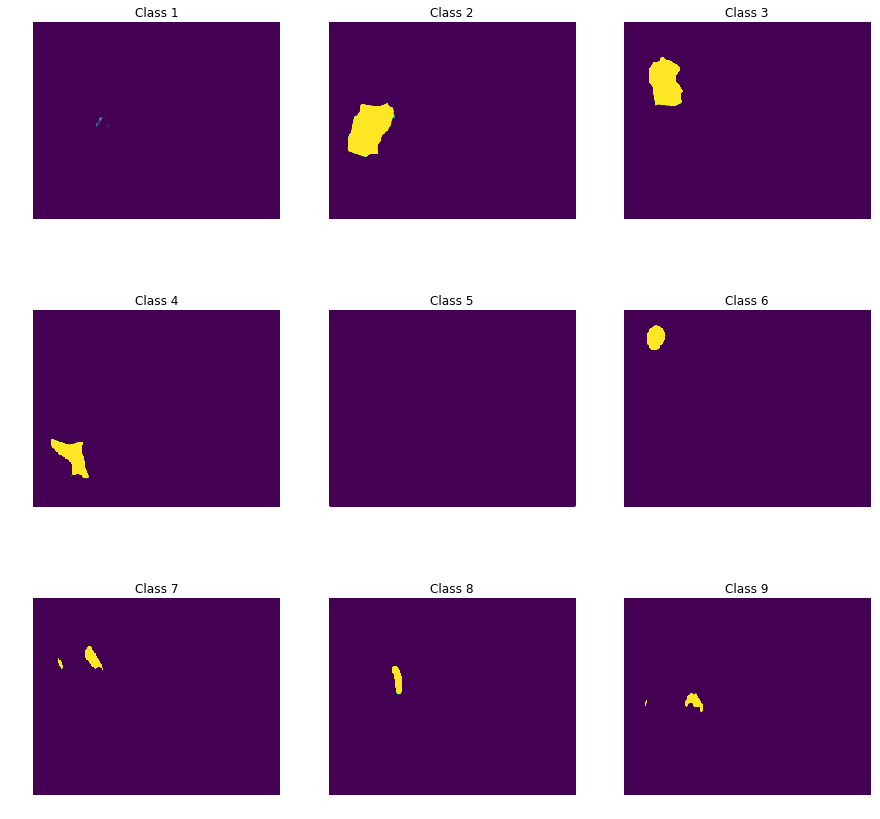

In [32]:
inputs, classes = next(iter(test_loader))
input_img = torch.unsqueeze(Variable(inputs.cuda(async=True)), dim=0)[0]
model_carvana.cuda()
model_carvana.eval()
output = model_carvana(input_img).data.cpu().numpy()

show_pics(output3, 3, 3)

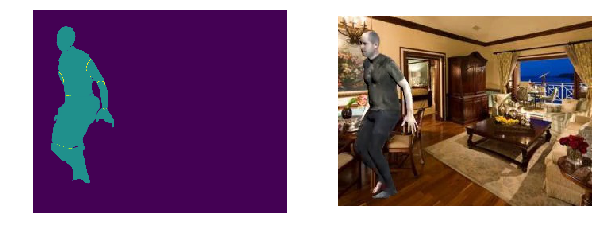

In [35]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.sum(output[3], axis=0))
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(plt.imread(test_loader.dataset.get_curr_pic()[3]))
plt.axis('off');

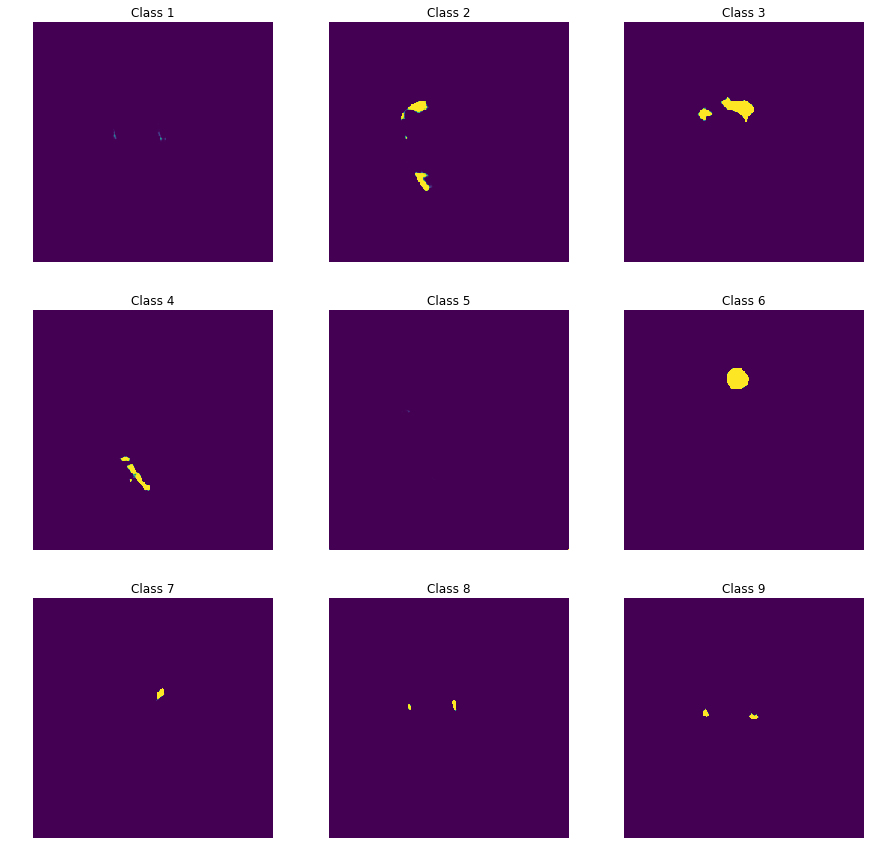

In [36]:
inputs_sit, classes_sit = next(iter(sitting_loader))
input_img_sit = torch.unsqueeze(Variable(inputs_sit.cuda(async=True)), dim=0)[0]
model_carvana.cuda()
model_carvana.eval()
output_sit = model_carvana(input_img_sit).data.cpu().numpy()

show_pics(output_sit[3], 3, 3)

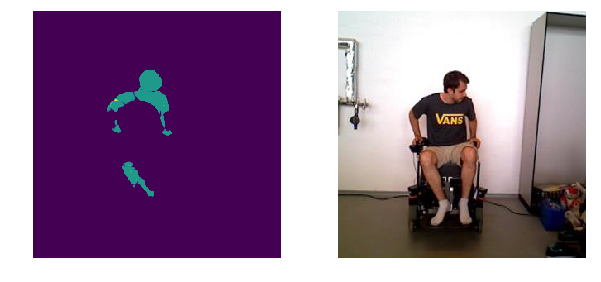

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(np.sum(output_sit[3], axis=0))
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(plt.imread(sitting_loader.dataset.get_curr_pic()[3]))
plt.axis('off');

## Loss story:

In [81]:
loss_tr = np.zeros((num_epochs))
for j in [k for k in os.listdir('params/') if 'ternaus' in k ]:
    loss_tr[int(j.split('_')[1][-2:])-1] = (torch.load('params/'+j)['min_loss'])

Text(0.5,0,'Number of epoch')

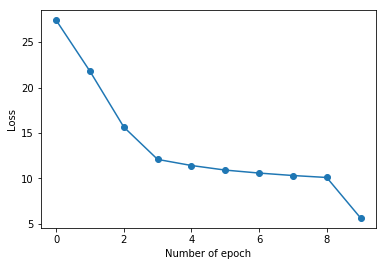

In [84]:
plt.plot(np.arange(0, num_epochs), loss_tr, '-o')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')

**Not normalized loss :(**

## Domain Adaptation Theory

$X$ - input space, $Y = {0, 1, \dots, L-1}$ - set of possible labels.<br>
*Source domain* $D_{S}$ and *target domain* $D_{T}$ are two *different* distributions over $X\times Y$.

An *unsupervised domain adaptation* learning algorithm is then provided with a *labeled source sample* $S$ drawn $i.i.d.$ from $D_{S}$, and *unlabeled target sample* $T$ drawn $i.i.d.$ from $D_{T}^{X}$ - *marginal distribution* of $D_{T}$ over X,

* $\quad S = \{(x_i, y_i)\}_{i=1}^{n} \sim (D_{S})^{n}, \quad T = \{x_{i}\}_{n+1}^{N} \sim (D_{T}^{X})^{n'}$,

with $N = n + n'$ being the total number of samples. The goal of learning algotithm is to build a classifier $\eta : X \rightarrow Y$ with a low **target risk**

* $ \quad R_{D_{T}}(\eta) = Pr_{(x, y) \sim D_{T}}(\eta(x) \neq y)$,

while having no information about labels of $D_{T}$.

(In definition 1 below the hypothesis class $ \mathscr{H}$ is (discrete or continuous) set of binary classifiers $\eta : X \rightarrow \{0, 1\}$. However Ben-David mentions that same analysis holds for multiclass settings. However, to obtain the same results when $|Y| \gt 2$, one should assume that \mathscr{H} is a symmetrical hypothesis class. That is, for all $h \in \mathscr{H}$ and any permutation of labels $c : Y \rightarrow Y$ we have $c(h) \in \mathscr{H}$.)

### Theorem (Ben-David et al., 2006):

Let $\large \mathscr{H}$ be a *hypothessis class* of Vapnik–Chervonenkis(VC) dimension d. With probability $1 - \delta$ over the choice of samples $S \sim (D_{s})^{n}$ and $T \sim (D_{T}^{X})^{n}$ for every $\eta \in \large \mathscr{H}$: 

* $ \quad R_{D_{T}}(\eta) \leq R_{S}(\eta) + \sqrt{\frac{4}{n} (d \log{\frac{2en}{d}} + log{\frac{4}{\delta}})} + \hat{d}_{\mathscr{H}}(S, T) +  4\sqrt{\frac{1}{n} (d \log{\frac{2n}{d}} + log{\frac{4}{\delta}})}  + \beta$, 

with $\beta \geq \inf\limits_{\substack \eta^{*}\in\mathscr{H}} [R_{D_{T}}(\eta^*) + R_{D_{S}}(\eta)]$, and

*  $ \quad R_{S}(\eta) = \frac{1}{n} \sum\limits_{i=1}^{m} I[\eta(x_i) \neq y_i]$

is the *empirical source risk*.


* $R_{D_{T}}(\eta)$ can be low *only* when the $\beta$ term is low, *i.e.*, only when there *exist a classifier that can achieve a low risk on both distributions*. Also this theorem tells us to find a classifier with small $R_{D_{T}}(\eta)$ in a give class of fixed VC dimension, the learning algorithm should minimize (in that class) a trade-off between **the source risk** $R_{S}(\eta)$ and the **empirical $\large \mathscr{H}-$divergence** $\hat{d}_{\mathscr{H}}(S, T)$.

# *In progress*